<a href="https://colab.research.google.com/github/johannnamr/Discrepancy-based-inference-using-QMC/blob/main/Inference/VAE/vae_times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling from a VAE using MC and RQMC

Notebook comparing the computational time needed for sampling from a VAE using MC and RQMC

## Mount drive

In [1]:
# mount my drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Set path for saving the results (adjust if necessary):

In [2]:
path = '/content/drive/My Drive/Colab Notebooks/Paper/Inference/'

## Imports

In [3]:
! pip install tensorflow==1.15.0
! pip install --upgrade scipy # update scipy to latest version

     |████████████████████████████████| 412.3 MB 24 kB/s 
     |████████████████████████████████| 3.8 MB 77.9 MB/s 
     |████████████████████████████████| 503 kB 49.8 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=e50f7f98acf03f31671f43b33165e2535c4d168aff8a7d1bb324739da3dc5cc9
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [4]:
import time
import numpy as np
import tensorflow as tf
from scipy.stats import qmc
import matplotlib.pyplot as plt

## Parameters

In [5]:
np.random.seed(11)

Set parameters:

In [6]:
n = [ 2**j for j in range(4,20) ]         # sample size                              
num = 500                                # numbers of repetitions for MC and RQMC
seed = 3                                  # seed
runall = False                             # True: run all simulations, False: load saved simulations

## Define useful functions

In [7]:
# define some useful functions

def init_xavier(n_in,n_out):
    '''Create a convolution filter variable with the specified name and shape,
    and initialize it using Xavier initialition.'''
    initializer = tf.contrib.layers.xavier_initializer()
    variable = tf.Variable(initializer(shape=[n_in,n_out]))
    return variable

def cost_mat(X,Y,N,M):
    XX = tf.reduce_sum(tf.multiply(X,X),axis=1)
    YY = tf.reduce_sum(tf.multiply(Y,Y),axis=1)
    C1 = tf.transpose(tf.reshape(tf.tile(XX,[M]),[M,N]))
    C2 = tf.reshape(tf.tile(YY,[N]),[N,M])
    C3 = tf.transpose(tf.matmul(Y,tf.transpose(X)))
    C = C1 + C2 - 2*C3;
    return C

def K_tild(u,v,C,N,M,epsilon):
    C_tild = C - tf.transpose(tf.reshape(tf.tile(u[:,0],[M]),[M,N])) - tf.reshape(tf.tile(v[:,0],[N]),[N,M])
    K_tild = tf.exp(-C_tild/epsilon)
    return K_tild

def sinkhorn_step_log(j,u,v,C, N,M,epsilon,Lambda = 1):
    mu = tf.cast(1/N, tf.float32)
    nu = tf.cast(1/M, tf.float32)
    Ku = tf.reshape( tf.reduce_sum(K_tild(u,v,C,N,M,epsilon),axis = 1) ,[N,1] )
    u = Lambda * ( epsilon*(tf.log(mu) - tf.log(Ku +10**(-6))) + u )
    Kv = tf.reshape( tf.reduce_sum(K_tild(u,v,C,N,M,epsilon),axis = 0), [M,1] )
    v = Lambda * ( epsilon*(tf.log(nu) - tf.log(Kv +10**(-6))) + v )
    j += 1
    return j,u,v,C,N,M,epsilon

def sinkhorn_loss(X,Y):
    epsilon = tf.constant(1.) # smoothing sinkhorn
    Lambda = tf.constant(1.) # unbalanced parameter
    k = tf.constant(50) # number of iterations for sinkhorn
    N = tf.shape(X)[0] # sample size from mu_theta
    M = tf.shape(Y)[0] # sample size from \hat nu
    D = tf.shape(Y)[1] # dimension of the obervation space
    C = cost_mat(X,Y,N,M)
    K = tf.exp(-C/epsilon)
    #sinkhorn iterations
    j0 = tf.constant(0)
    u0 = tf.zeros([N,1])
    v0 = tf.zeros([M,1])
    cond_iter = lambda j, u, v, C, N, M, epsilon: j < k
    j,u,v,C,N,M,epsilon = tf.while_loop(
    cond_iter, sinkhorn_step_log, loop_vars=[j0, u0, v0,C, N,M,epsilon])
    gamma_log = K_tild(u,v,C,N,M,epsilon)
    final_cost = tf.reduce_sum(gamma_log*C)
    return final_cost

## Define variational autoencoder class 

In [8]:
# Variational Autoencoder class


class VariationalAutoencoder(object):
    
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [batch_size, network_architecture["n_input"]])
      
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.Session()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        self.network_weights = self._initialize_weights(**self.network_architecture)

        # Draw one sample z from uniform in latent space
        n_z = self.network_architecture["n_z"]
        self.z = tf.random_uniform((self.batch_size, n_z), dtype=tf.float32)
        
        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr =   self._generator_network(self.network_weights["weights_gener"],
                                    self.network_weights["biases_gener"])
    
    def _initialize_weights(self, n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_gener'] = {
            'h1': init_xavier(n_z, n_hidden_gener_1),
            'h2': init_xavier(n_hidden_gener_1, n_hidden_gener_2),
            'out_var': init_xavier(n_hidden_gener_2, n_input)}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_var': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights        
   

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_var']), 
                                 biases['out_var']))
        return x_reconstr
            
    def _create_loss_optimizer(self):
        # Sinkhorn loss
        self.cost = sinkhorn_loss(self.x, self.x_reconstr)   # average over batch
        # Use ADAM optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost    
   
    def generate(self, n, z_sample):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        
        zz = tf.placeholder(tf.float32, [n, network_architecture["n_z"]])

        
        weights = self.network_weights["weights_gener"]
        biases = self.network_weights["biases_gener"]
        
        layer_1 = self.transfer_fct(tf.add(tf.matmul(zz, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_var']), 
                                 biases['out_var']))
        
        return self.sess.run(x_reconstr,feed_dict={zz: np.reshape(z_sample,[n,network_architecture["n_z"]])})

## Initialise the model

In [9]:
# initialise the model

network_architecture =     dict(n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae = VariationalAutoencoder(network_architecture, learning_rate=0.005, batch_size=300)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Sampling

Use `vae.generate()` with either MC or QMC samples as input

Sampling using RQMC:

In [10]:
# RQMC

if runall:
  times_rqmc = np.zeros((len(n),num))
  for i in range(len(n)):
    print(i)
    for rep in range(num):
      start_rqmc = time.time()
      sampler = qmc.Sobol(d=2, scramble=True, seed = seed)
      z_rqmc = sampler.random(n[i])                 
      y_rqmc = vae.generate(n[i],z_rqmc)
      end_rqmc = time.time()
      times_rqmc[i,rep] = end_rqmc - start_rqmc

  print("RQMC:")    
  print(np.mean(times_rqmc,axis=1))
  np.savez(path+"vae_times_rqmc.npz",times=times_rqmc)

Sampling using MC:

In [11]:
# MC

if runall:
  times_mc = np.zeros((len(n),num))
  for i in range(len(n)):
    print(i)
    for rep in range(num):
      start_mc = time.time()
      z_mc = np.random.rand(n[i],2)        
      y_mc = vae.generate(n[i],z_mc)
      end_mc = time.time()
      times_mc[i,rep] = end_mc - start_mc

  print("MC:")    
  print(np.mean(times_mc,axis=1))
  np.savez(path+"vae_times_mc.npz",times=times_mc)

## Plot sample size against computational cost

In [12]:
if runall==False:
  times_mc = np.load(path+'vae_times_mc.npz')
  times_rqmc = np.load(path+'vae_times_rqmc.npz')

  times_mc = times_mc['times']
  times_rqmc = times_rqmc['times']

In [19]:
SMALL_SIZE = 28
MEDIUM_SIZE = 32
BIGGER_SIZE = 32

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

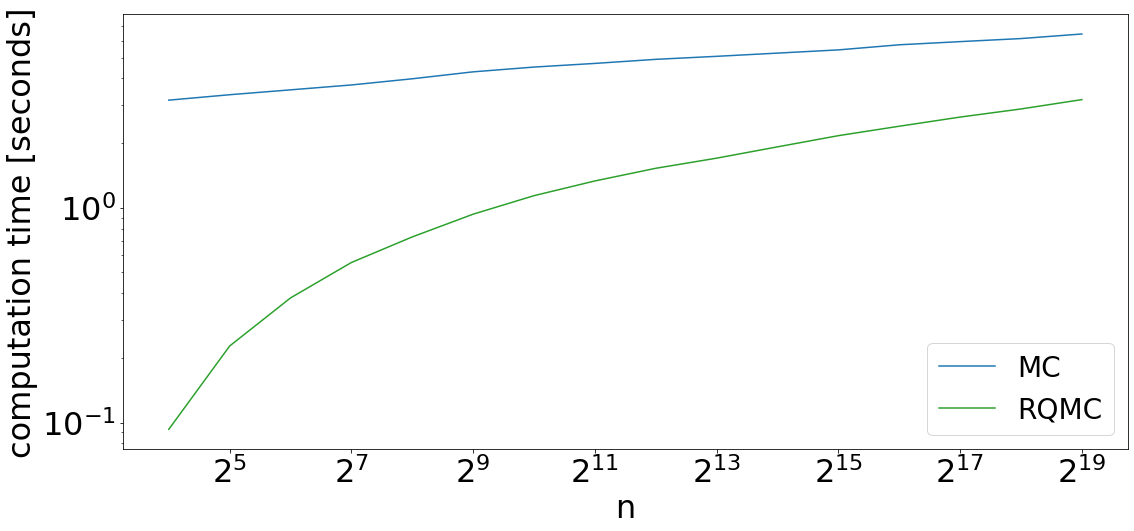

In [18]:
if runall==False:
  plt.figure(figsize=(18,8))
  cmap = plt.get_cmap("tab10")

  plt.plot(n, np.mean(times_mc,axis=1), label="MC", color=cmap(0))
  plt.plot(n, np.mean(times_rqmc,axis=1), label="RQMC", color=cmap(2))
  plt.xscale('log', basex=2)
  plt.xlabel('n')
  plt.yscale('log', basey=10)
  plt.ylabel('computation time [seconds]')
  plt.legend(loc='lower right')

  plt.savefig('vae_mc_vs_qmc_time.png',bbox_inches = 'tight', pad_inches = .1)
  plt.show()